# **Lunar Lander con Q-Learning**

### **1. Bibliotecas**

In [1]:
import sys
# Tal vez tengan que ejecutar lo siguiente en sus máquinas (ubuntu 20.04)
# sudo apt-get remove swig
# sudo apt-get install swig3.0
# sudo ln -s /usr/bin/swig3.0 /usr/bin/swig
# En windows tambien puede ser necesario MSVC++
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

### **2. Jugando a mano**

A continuación se puede jugar un episodio del lunar lander. Se controlan los motores con el teclado. Notar que solo se puede realizar una acción a la vez (que es parte del problema), y que en esta implementación, izq toma precedencia sobre derecha, que toma precedencia sobre el motor principal.

In [2]:
# Nota: hay que transformar esta celda en código para ejecutar (Esc + y)

import pygame
from pygame.locals import *

# Inicializar pygame (para el control con el teclado) y el ambiente
pygame.init()
env = gym.make('LunarLander-v2', render_mode='human')
env.reset()
pygame.display.set_caption('Lunar Lander')

clock = pygame.time.Clock()
done = False

while not done:
    for event in pygame.event.get():
        if event.type == QUIT:
            done = True
            break

    keys = pygame.key.get_pressed()

    # Map keys to actions
    if keys[K_LEFT]:
        action = 3  # Fire left orientation engine
    elif keys[K_RIGHT]:
        action = 1 # Fire right orientation engine
    elif keys[K_UP]:
        action = 2  # Fire main engine
    else:
        action = 0  # Do nothing

    _, _, terminated, truncated, _ = env.step(action)
    env.render()
    clock.tick(10)

    if terminated or truncated:
        done = True

env.close()
pygame.quit()

## **3. Discretizando el estado**

El estado consiste de posiciones y velocidades en (x,y,theta) y en información de contacto de los pies con la superficie.

Como varios de estos son continuos, tenemos que discretizarlos para aplicar nuestro algoritmo de aprendizaje por refuerzo tabular.

In [3]:
# Cuántos bins queremos por dimensión
# Pueden considerar variar este parámetro
bins_per_dim = 15

# Estado:
# (x, y, x_vel, y_vel, theta, theta_vel, pie_izq_en_contacto, pie_derecho_en_contacto)
NUM_BINS = [bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, 2, 2]

env = gym.make('LunarLander-v2')
env.reset()

# Tomamos los rangos del env
OBS_SPACE_HIGH = env.observation_space.high
OBS_SPACE_LOW = env.observation_space.low
OBS_SPACE_LOW[1] = 0 # Para la coordenada y (altura), no podemos ir más abajo que la zona dea aterrizae (que está en el 0, 0)

# Los bins para cada dimensión
bins = [
    np.linspace(OBS_SPACE_LOW[i], OBS_SPACE_HIGH[i], NUM_BINS[i] - 1)
    for i in range(len(NUM_BINS) - 2) # last two are binary
]
# Se recomienda observar los bins para entender su estructura
#print ("Bins: ", bins)
print("High: ", OBS_SPACE_HIGH)
print("Low: ", OBS_SPACE_LOW)
def discretize_state(state, bins):
    """Discretize the continuous state into a tuple of discrete indices."""
    state_disc = list()
    for i in range(len(state)):
        if i >= len(bins):  # For binary features (leg contacts)
            state_disc.append(int(state[i]))
        else:
            state_disc.append(
                np.digitize(state[i], bins[i])
            )
    return tuple(state_disc)

High:  [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ]
Low:  [-1.5        0.        -5.        -5.        -3.1415927 -5.
 -0.        -0.       ]


In [ ]:
# Ejemplos
print(discretize_state([0.0, 0.0, 0, 0, 0, 0, 1, 1], bins)) # En la zona de aterrizaje y quieto
print(discretize_state([0, 1.5, 0, 0, 0, 0, 0, 0], bins)) # Comenzando la partida, arriba y en el centro

(np.int64(7), np.int64(1), np.int64(7), np.int64(7), np.int64(7), np.int64(7), 1, 1)
(np.int64(7), np.int64(14), np.int64(7), np.int64(7), np.int64(7), np.int64(7), 0, 0)


## **4. Agentes y la interacción con el entorno**

Vamos a definir una interfaz para nuestro agente:

In [5]:
class Agente:
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        """Elegir la accion a tomar en el estado actual y el espacio de acciones
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó
        """
        pass

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        """Aprender a partir de la tupla 
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó en esta transición
        """
        pass

    def fin_episodio(self):
        """Actualizar estructuras al final de un episodio"""
        pass

Para un agente aleatorio, la implementación sería:

In [6]:
import random

class AgenteAleatorio(Agente):
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        # Elige una acción al azar
        return random.randrange(max_accion)

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        # No aprende
        pass

    def fin_episodio(self):
        # Nada que actualizar
        pass

Luego podemos definir una función para ejecutar un episodio con un agente dado:

In [7]:
def ejecutar_episodio_2(agente, aprender=True, max_iteraciones=500):
    entorno = gym.make('LunarLander-v2').env
    semilla = entorno.np_random.bit_generator._seed_seq.entropy
    iteraciones = 0
    recompensa_total = 0
    episodio = []

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset(seed=semilla)
    while iteraciones < max_iteraciones and not termino and not truncado:
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n, aprender)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        if aprender:
            agente.aprender(estado_anterior, estado_siguiente, accion, recompensa, termino)

        # Almacenar el estado, acción y recompensa
        episodio.append((estado_anterior, accion, recompensa))

        estado_anterior = estado_siguiente
        iteraciones += 1
        recompensa_total += recompensa

    if aprender:
        agente.fin_episodio()
    entorno.close()
    return recompensa_total, episodio, semilla

In [8]:
def ejecutar_episodio_1(agente, aprender = True, render = None, max_iteraciones=500):
    entorno = gym.make('LunarLander-v2', render_mode=render).env
    
    iteraciones = 0
    recompensa_total = 0

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset()
    while iteraciones < max_iteraciones and not termino and not truncado:
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n, aprender)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        if (aprender):
            agente.aprender(estado_anterior, estado_siguiente, accion, recompensa, termino)

        estado_anterior = estado_siguiente
        iteraciones += 1
        recompensa_total += recompensa
    if (aprender):
        agente.fin_episodio()
    entorno.close()
    return recompensa_total

In [9]:
# Nota: hay que transformar esta celda en código para ejecutar (Esc + y)

# Ejecutamos un episodio con el agente aleatorio y modo render 'human', para poder verlo
ejecutar_episodio_1(AgenteAleatorio(), render = 'human')

np.float64(-213.26767006459664)

Podemos ejecutar este ambiente muchas veces y tomar métricas al respecto

In [10]:
agente = AgenteAleatorio()
recompensa_episodios = []

exitos = 0
num_episodios = 100
for i in range(num_episodios):
    recompensa = ejecutar_episodio_1(agente)
    # Los episodios se consideran exitosos si se obutvo 200 o más de recompensa total
    if (recompensa >= 200):
        exitos += 1
    recompensa_episodios += [recompensa]

import numpy
print(f"Tasa de éxito: {exitos / num_episodios}. Se obtuvo {numpy.mean(recompensa_episodios)} de recompensa, en promedio")

Tasa de éxito: 0.0. Se obtuvo -167.8561863840643 de recompensa, en promedio


### **5. Programando un agente que aprende**

La tarea a realizar consiste en programar un agente de aprendizaje por refuerzos:

In [11]:
import numpy as np
import random
from collections import defaultdict
class AgenteRL(Agente):
    # Agregar código aqui

    # Pueden agregar parámetros al constructor
    def __init__(self, max_accion, bins, initial_epsilon: float, epsilon_decay: float, final_epsilon: float, discount_factor: float = 0.95):
        super().__init__()
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_table = defaultdict(lambda: np.zeros(max_accion))
        self.visitas = defaultdict(lambda: np.zeros(max_accion))

        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.bins = bins

        self.training_error = []
    
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:

        estado_discreto = discretize_state(estado, self.bins)
        if (explorar and np.random.random() < self.epsilon):
            return random.randrange(max_accion)
        else:
            return int(np.argmax(self.q_table[estado_discreto]))
    
    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        estado_anterior_discreto = discretize_state(estado_anterior, self.bins)
        estado_siguiente_discreto = discretize_state(estado_siguiente, self.bins)

        self.visitas[estado_anterior_discreto][accion] += 1

        """Updates the Q-value of an action."""
        future_q_value = (not terminado) * np.max(self.q_table[estado_siguiente_discreto])
        temporal_difference = (
            recompensa + self.discount_factor * future_q_value - self.q_table[estado_anterior_discreto][accion]
        )

        lr = 1 / self.visitas[estado_anterior_discreto][accion]

        self.q_table[estado_anterior_discreto][accion] = (
            self.q_table[estado_anterior_discreto][accion] + lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def fin_episodio(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

Y ejecutar con el muchos episodios:

In [12]:
# Nota: hay que transformar esta celda en código para ejecutar (Esc + y)
# Advertencia: este bloque es un loop infinito si el agente se deja sin implementar
from tqdm import tqdm 
entorno = gym.make('LunarLander-v2').env
num_episodios = 100000
max_accion = entorno.action_space.n
initial_epsilon = 1.0
epsilon_decay = initial_epsilon / (num_episodios / 2)
final_epsilon = 0.05
discount_factor = 0.95

agente = AgenteRL(max_accion = max_accion, bins = bins, initial_epsilon = initial_epsilon, epsilon_decay = epsilon_decay, final_epsilon = final_epsilon, discount_factor = discount_factor)
exitos = 0
recompensa_episodios = []
with tqdm(total=num_episodios) as pbar:
    for i in range(num_episodios):
        recompensa = ejecutar_episodio_1(agente)
        if i % 1000 == 0:
            ultimas_1000_recompensas = recompensa_episodios[-1000:]
            promedio_ultimas_1000 = np.mean(ultimas_1000_recompensas)
            print(f" Se obtuvo {promedio_ultimas_1000} de recompensa, en promedio en los últimos 1000 episodios")
        if (recompensa >= 200):
            exitos += 1
        recompensa_episodios += [recompensa]
        pbar.set_postfix(recompensa=recompensa, promedio=numpy.mean(recompensa_episodios))
        pbar.update(1)
print(f"Tasa de éxito: {exitos / num_episodios}. Se obtuvo {numpy.mean(recompensa_episodios)} de recompensa, en promedio")

  0%|          | 0/100000 [00:00<?, ?it/s]/home/julio/.local/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/julio/.local/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  0%|          | 10/100000 [00:00<23:52, 69.80it/s, promedio=-129, recompensa=-67.8]

 Se obtuvo nan de recompensa, en promedio en los últimos 1000 episodios


  1%|          | 1015/100000 [00:14<23:48, 69.28it/s, promedio=-176, recompensa=-182] 

 Se obtuvo -176.20306955016136 de recompensa, en promedio en los últimos 1000 episodios


  2%|▏         | 2015/100000 [00:28<22:24, 72.88it/s, promedio=-172, recompensa=-93]   

 Se obtuvo -168.58455704968458 de recompensa, en promedio en los últimos 1000 episodios


  3%|▎         | 3014/100000 [00:43<24:56, 64.80it/s, promedio=-170, recompensa=-67.2]

 Se obtuvo -165.46163947940332 de recompensa, en promedio en los últimos 1000 episodios


  4%|▍         | 4014/100000 [00:58<23:56, 66.83it/s, promedio=-167, recompensa=-34.7]

 Se obtuvo -159.1079779172706 de recompensa, en promedio en los últimos 1000 episodios


  5%|▌         | 5013/100000 [01:14<25:32, 61.99it/s, promedio=-166, recompensa=-260] 

 Se obtuvo -158.7408873799418 de recompensa, en promedio en los últimos 1000 episodios


  6%|▌         | 6012/100000 [01:29<25:27, 61.55it/s, promedio=-164, recompensa=-112]  

 Se obtuvo -155.35254596596806 de recompensa, en promedio en los últimos 1000 episodios


  7%|▋         | 7013/100000 [01:45<24:17, 63.79it/s, promedio=-162, recompensa=-145]  

 Se obtuvo -150.17517571563508 de recompensa, en promedio en los últimos 1000 episodios


  8%|▊         | 8012/100000 [02:01<24:06, 63.58it/s, promedio=-161, recompensa=-179] 

 Se obtuvo -151.87927619033982 de recompensa, en promedio en los últimos 1000 episodios


  9%|▉         | 9012/100000 [02:18<24:19, 62.32it/s, promedio=-159, recompensa=-130]  

 Se obtuvo -146.8368828739069 de recompensa, en promedio en los últimos 1000 episodios


 10%|█         | 10012/100000 [02:35<24:38, 60.88it/s, promedio=-158, recompensa=-222] 

 Se obtuvo -143.9601472971231 de recompensa, en promedio en los últimos 1000 episodios


 11%|█         | 11010/100000 [02:52<27:14, 54.45it/s, promedio=-156, recompensa=-85.2] 

 Se obtuvo -142.86026410001023 de recompensa, en promedio en los últimos 1000 episodios


 12%|█▏        | 12011/100000 [03:10<25:42, 57.04it/s, promedio=-155, recompensa=-103]  

 Se obtuvo -137.4240653922457 de recompensa, en promedio en los últimos 1000 episodios


 13%|█▎        | 13011/100000 [03:28<26:33, 54.60it/s, promedio=-154, recompensa=-249] 

 Se obtuvo -142.8441402646452 de recompensa, en promedio en los últimos 1000 episodios


 14%|█▍        | 14011/100000 [03:46<26:38, 53.78it/s, promedio=-153, recompensa=-95]  

 Se obtuvo -138.38076475013256 de recompensa, en promedio en los últimos 1000 episodios


 15%|█▌        | 15010/100000 [04:05<26:07, 54.23it/s, promedio=-151, recompensa=-52.4]  

 Se obtuvo -135.12216095934767 de recompensa, en promedio en los últimos 1000 episodios


 16%|█▌        | 16010/100000 [04:25<27:06, 51.65it/s, promedio=-150, recompensa=-72.6] 

 Se obtuvo -133.26765784015387 de recompensa, en promedio en los últimos 1000 episodios


 17%|█▋        | 17009/100000 [04:45<28:52, 47.90it/s, promedio=-149, recompensa=-14.5] 

 Se obtuvo -132.51086075105795 de recompensa, en promedio en los últimos 1000 episodios


 18%|█▊        | 18009/100000 [05:05<28:50, 47.37it/s, promedio=-148, recompensa=-155] 

 Se obtuvo -127.21578470564357 de recompensa, en promedio en los últimos 1000 episodios


 19%|█▉        | 19009/100000 [05:27<28:09, 47.95it/s, promedio=-147, recompensa=-268]  

 Se obtuvo -129.21646835441652 de recompensa, en promedio en los últimos 1000 episodios


 20%|██        | 20007/100000 [05:48<32:30, 41.02it/s, promedio=-146, recompensa=-15.3]  

 Se obtuvo -122.18803071527458 de recompensa, en promedio en los últimos 1000 episodios


 21%|██        | 21009/100000 [06:11<29:02, 45.34it/s, promedio=-145, recompensa=-144]  

 Se obtuvo -121.53665952756339 de recompensa, en promedio en los últimos 1000 episodios


 22%|██▏       | 22009/100000 [06:33<29:16, 44.41it/s, promedio=-143, recompensa=-40.7]

 Se obtuvo -117.97024039640733 de recompensa, en promedio en los últimos 1000 episodios


 23%|██▎       | 23008/100000 [06:57<31:09, 41.18it/s, promedio=-142, recompensa=-20.3]  

 Se obtuvo -113.37676902189827 de recompensa, en promedio en los últimos 1000 episodios


 24%|██▍       | 24009/100000 [07:21<27:56, 45.34it/s, promedio=-141, recompensa=-91.6]

 Se obtuvo -107.28474518095285 de recompensa, en promedio en los últimos 1000 episodios


 25%|██▌       | 25007/100000 [07:46<29:47, 41.95it/s, promedio=-139, recompensa=-57]   

 Se obtuvo -108.36310796595345 de recompensa, en promedio en los últimos 1000 episodios


 26%|██▌       | 26007/100000 [08:12<31:15, 39.46it/s, promedio=-138, recompensa=-181]  

 Se obtuvo -97.97960686353564 de recompensa, en promedio en los últimos 1000 episodios


 27%|██▋       | 27007/100000 [08:38<34:07, 35.65it/s, promedio=-137, recompensa=-10.4]

 Se obtuvo -102.45713854879091 de recompensa, en promedio en los últimos 1000 episodios


 28%|██▊       | 28009/100000 [09:05<30:38, 39.16it/s, promedio=-135, recompensa=-10.5]  

 Se obtuvo -103.85964808473206 de recompensa, en promedio en los últimos 1000 episodios


 29%|██▉       | 29006/100000 [09:34<34:15, 34.54it/s, promedio=-134, recompensa=38.8]   

 Se obtuvo -98.02357015753726 de recompensa, en promedio en los últimos 1000 episodios


 30%|███       | 30006/100000 [10:03<32:47, 35.57it/s, promedio=-133, recompensa=-191]  

 Se obtuvo -100.46459105726052 de recompensa, en promedio en los últimos 1000 episodios


 31%|███       | 31006/100000 [10:33<33:03, 34.79it/s, promedio=-132, recompensa=33.9]  

 Se obtuvo -99.92854027665537 de recompensa, en promedio en los últimos 1000 episodios


 32%|███▏      | 32007/100000 [11:04<40:04, 28.27it/s, promedio=-131, recompensa=-75.6] 

 Se obtuvo -101.03048510343919 de recompensa, en promedio en los últimos 1000 episodios


 33%|███▎      | 33007/100000 [11:36<35:30, 31.45it/s, promedio=-130, recompensa=-136]  

 Se obtuvo -101.78840261668623 de recompensa, en promedio en los últimos 1000 episodios


 34%|███▍      | 34007/100000 [12:09<32:42, 33.63it/s, promedio=-129, recompensa=-43]  

 Se obtuvo -101.10094086445297 de recompensa, en promedio en los últimos 1000 episodios


 35%|███▌      | 35006/100000 [12:42<36:13, 29.90it/s, promedio=-129, recompensa=-51.9]

 Se obtuvo -111.42594856315334 de recompensa, en promedio en los últimos 1000 episodios


 36%|███▌      | 36007/100000 [13:18<35:43, 29.86it/s, promedio=-128, recompensa=-9.97] 

 Se obtuvo -104.51410070033143 de recompensa, en promedio en los últimos 1000 episodios


 37%|███▋      | 37005/100000 [13:54<41:15, 25.45it/s, promedio=-127, recompensa=-21.9] 

 Se obtuvo -103.65329802082564 de recompensa, en promedio en los últimos 1000 episodios


 38%|███▊      | 38005/100000 [14:31<40:37, 25.44it/s, promedio=-127, recompensa=-241]   

 Se obtuvo -111.67078293544165 de recompensa, en promedio en los últimos 1000 episodios


 39%|███▉      | 39005/100000 [15:10<35:00, 29.04it/s, promedio=-126, recompensa=-94.2] 

 Se obtuvo -103.45041726835494 de recompensa, en promedio en los últimos 1000 episodios


 40%|████      | 40003/100000 [15:50<49:56, 20.02it/s, promedio=-126, recompensa=-8]    

 Se obtuvo -104.60225973359674 de recompensa, en promedio en los últimos 1000 episodios


 41%|████      | 41004/100000 [16:31<41:35, 23.64it/s, promedio=-125, recompensa=-38.9] 

 Se obtuvo -101.93500672048663 de recompensa, en promedio en los últimos 1000 episodios


 42%|████▏     | 42005/100000 [17:16<38:43, 24.96it/s, promedio=-124, recompensa=-46.4]  

 Se obtuvo -88.0468242493674 de recompensa, en promedio en los últimos 1000 episodios


 43%|████▎     | 43004/100000 [18:01<49:43, 19.11it/s, promedio=-124, recompensa=-26.3] 

 Se obtuvo -89.05275206261216 de recompensa, en promedio en los últimos 1000 episodios


 44%|████▍     | 44003/100000 [18:48<47:15, 19.75it/s, promedio=-123, recompensa=148]   

 Se obtuvo -83.45103475213607 de recompensa, en promedio en los últimos 1000 episodios


 45%|████▌     | 45004/100000 [19:39<47:30, 19.30it/s, promedio=-122, recompensa=-94]    

 Se obtuvo -82.17346974011646 de recompensa, en promedio en los últimos 1000 episodios


 46%|████▌     | 46003/100000 [20:31<49:48, 18.07it/s, promedio=-121, recompensa=-30.9] 

 Se obtuvo -73.87556624901248 de recompensa, en promedio en los últimos 1000 episodios


 47%|████▋     | 47004/100000 [21:24<47:43, 18.50it/s, promedio=-119, recompensa=-146]  

 Se obtuvo -61.260104040343414 de recompensa, en promedio en los últimos 1000 episodios


 48%|████▊     | 48003/100000 [22:18<55:14, 15.69it/s, promedio=-118, recompensa=-87.7]   

 Se obtuvo -60.65530129991435 de recompensa, en promedio en los últimos 1000 episodios


 49%|████▉     | 49005/100000 [23:14<42:11, 20.14it/s, promedio=-116, recompensa=-50.7] 

 Se obtuvo -31.82597938227421 de recompensa, en promedio en los últimos 1000 episodios


 50%|█████     | 50004/100000 [11:16:14<41:27, 20.10it/s, promedio=-115, recompensa=-261]         

 Se obtuvo -33.21386455013932 de recompensa, en promedio en los últimos 1000 episodios


 51%|█████     | 51002/100000 [11:17:08<58:00, 14.08it/s, promedio=-113, recompensa=14.5]   

 Se obtuvo -29.54613436041704 de recompensa, en promedio en los últimos 1000 episodios


 52%|█████▏    | 52004/100000 [11:17:58<36:03, 22.18it/s, promedio=-111, recompensa=-11.6] 

 Se obtuvo -20.90664881960447 de recompensa, en promedio en los últimos 1000 episodios


 53%|█████▎    | 53003/100000 [11:18:51<46:00, 17.03it/s, promedio=-109, recompensa=-226]  

 Se obtuvo -15.81359331501125 de recompensa, en promedio en los últimos 1000 episodios


 54%|█████▍    | 54004/100000 [11:19:42<39:12, 19.55it/s, promedio=-108, recompensa=-86.6] 

 Se obtuvo -13.776607445514081 de recompensa, en promedio en los últimos 1000 episodios


 55%|█████▌    | 55003/100000 [11:20:33<38:46, 19.34it/s, promedio=-106, recompensa=23]    

 Se obtuvo -16.21237526928025 de recompensa, en promedio en los últimos 1000 episodios


 56%|█████▌    | 56004/100000 [11:21:25<30:13, 24.26it/s, promedio=-104, recompensa=-110]  

 Se obtuvo -14.007025900390015 de recompensa, en promedio en los últimos 1000 episodios


 57%|█████▋    | 57002/100000 [11:22:17<45:31, 15.74it/s, promedio=-103, recompensa=-48.5] 

 Se obtuvo -8.022534792624263 de recompensa, en promedio en los últimos 1000 episodios


 58%|█████▊    | 58004/100000 [11:23:12<31:25, 22.27it/s, promedio=-101, recompensa=21.2]   

 Se obtuvo 0.4943447479674885 de recompensa, en promedio en los últimos 1000 episodios


 59%|█████▉    | 59004/100000 [11:24:07<37:15, 18.34it/s, promedio=-99.3, recompensa=-74.7] 

 Se obtuvo -4.397104725753646 de recompensa, en promedio en los últimos 1000 episodios


 60%|██████    | 60004/100000 [11:25:00<34:44, 19.19it/s, promedio=-97.5, recompensa=216]   

 Se obtuvo 8.270102077599189 de recompensa, en promedio en los últimos 1000 episodios


 61%|██████    | 61003/100000 [11:25:55<45:03, 14.42it/s, promedio=-95.7, recompensa=247]   

 Se obtuvo 11.890214641862682 de recompensa, en promedio en los últimos 1000 episodios


 62%|██████▏   | 62004/100000 [11:26:50<29:09, 21.71it/s, promedio=-93.9, recompensa=-154]  

 Se obtuvo 15.823264689745278 de recompensa, en promedio en los últimos 1000 episodios


 63%|██████▎   | 63004/100000 [11:27:46<32:15, 19.11it/s, promedio=-92.1, recompensa=-117]  

 Se obtuvo 22.51420421786917 de recompensa, en promedio en los últimos 1000 episodios


 64%|██████▍   | 64003/100000 [11:28:42<33:26, 17.94it/s, promedio=-90.7, recompensa=-67.4]  

 Se obtuvo -1.3360442575567135 de recompensa, en promedio en los últimos 1000 episodios


 65%|██████▌   | 65003/100000 [11:29:38<35:34, 16.39it/s, promedio=-89.2, recompensa=14.9]  

 Se obtuvo 6.761501582062048 de recompensa, en promedio en los últimos 1000 episodios


 66%|██████▌   | 66005/100000 [11:30:34<27:17, 20.76it/s, promedio=-87.6, recompensa=-51.4] 

 Se obtuvo 15.120121176698643 de recompensa, en promedio en los últimos 1000 episodios


 67%|██████▋   | 67003/100000 [11:31:29<31:19, 17.56it/s, promedio=-86.1, recompensa=-8.95]  

 Se obtuvo 9.070306314105679 de recompensa, en promedio en los últimos 1000 episodios


 68%|██████▊   | 68004/100000 [11:32:26<32:21, 16.48it/s, promedio=-84.7, recompensa=-43.1] 

 Se obtuvo 10.756541416967181 de recompensa, en promedio en los últimos 1000 episodios


 69%|██████▉   | 69004/100000 [11:33:24<29:33, 17.48it/s, promedio=-83.4, recompensa=297]   

 Se obtuvo 7.286203244695063 de recompensa, en promedio en los últimos 1000 episodios


 70%|███████   | 70003/100000 [11:34:20<23:57, 20.86it/s, promedio=-81.9, recompensa=217]   

 Se obtuvo 21.06394025718615 de recompensa, en promedio en los últimos 1000 episodios


 71%|███████   | 71003/100000 [11:35:18<27:42, 17.44it/s, promedio=-80.5, recompensa=211]   

 Se obtuvo 18.14391420208414 de recompensa, en promedio en los últimos 1000 episodios


 72%|███████▏  | 72002/100000 [11:36:16<25:24, 18.36it/s, promedio=-79, recompensa=262]     

 Se obtuvo 22.437774605711684 de recompensa, en promedio en los últimos 1000 episodios


 73%|███████▎  | 73003/100000 [11:37:13<25:24, 17.70it/s, promedio=-77.8, recompensa=-63.9] 

 Se obtuvo 13.195077323798824 de recompensa, en promedio en los últimos 1000 episodios


 74%|███████▍  | 74003/100000 [11:38:12<26:38, 16.26it/s, promedio=-76.3, recompensa=-71.2] 

 Se obtuvo 28.859037789585408 de recompensa, en promedio en los últimos 1000 episodios


 75%|███████▌  | 75003/100000 [11:39:08<25:52, 16.10it/s, promedio=-75, recompensa=259]     

 Se obtuvo 27.3869574987898 de recompensa, en promedio en los últimos 1000 episodios


 76%|███████▌  | 76002/100000 [11:40:05<23:21, 17.12it/s, promedio=-73.6, recompensa=36.5]  

 Se obtuvo 31.890808839518634 de recompensa, en promedio en los últimos 1000 episodios


 77%|███████▋  | 77004/100000 [11:41:03<21:42, 17.66it/s, promedio=-72.2, recompensa=50.6]  

 Se obtuvo 33.09361573907141 de recompensa, en promedio en los últimos 1000 episodios


 78%|███████▊  | 78004/100000 [11:42:01<22:37, 16.21it/s, promedio=-70.7, recompensa=185]   

 Se obtuvo 41.41472925618187 de recompensa, en promedio en los últimos 1000 episodios


 79%|███████▉  | 79003/100000 [11:42:58<19:10, 18.25it/s, promedio=-69.2, recompensa=-147]  

 Se obtuvo 52.35827025292043 de recompensa, en promedio en los últimos 1000 episodios


 80%|████████  | 80003/100000 [11:43:56<20:06, 16.58it/s, promedio=-67.7, recompensa=63]     

 Se obtuvo 47.237797991818795 de recompensa, en promedio en los últimos 1000 episodios


 81%|████████  | 81004/100000 [11:44:52<17:29, 18.10it/s, promedio=-66.4, recompensa=-190]  

 Se obtuvo 39.440168800262626 de recompensa, en promedio en los últimos 1000 episodios


 82%|████████▏ | 82002/100000 [11:45:49<17:21, 17.27it/s, promedio=-65.1, recompensa=-173]  

 Se obtuvo 37.35540363606143 de recompensa, en promedio en los últimos 1000 episodios


 83%|████████▎ | 83004/100000 [11:46:48<15:32, 18.23it/s, promedio=-63.9, recompensa=44.2]   

 Se obtuvo 38.041067483988506 de recompensa, en promedio en los últimos 1000 episodios


 84%|████████▍ | 84003/100000 [11:47:48<14:07, 18.88it/s, promedio=-62.5, recompensa=276]   

 Se obtuvo 50.105681601054236 de recompensa, en promedio en los últimos 1000 episodios


 85%|████████▌ | 85004/100000 [11:48:45<15:17, 16.35it/s, promedio=-61.3, recompensa=-196]   

 Se obtuvo 36.8159332732155 de recompensa, en promedio en los últimos 1000 episodios


 86%|████████▌ | 86002/100000 [11:49:43<16:12, 14.40it/s, promedio=-60.2, recompensa=164]   

 Se obtuvo 34.707313284070345 de recompensa, en promedio en los últimos 1000 episodios


 87%|████████▋ | 87003/100000 [11:50:43<11:31, 18.80it/s, promedio=-59.1, recompensa=160]    

 Se obtuvo 39.742129404525954 de recompensa, en promedio en los últimos 1000 episodios


 88%|████████▊ | 88003/100000 [11:51:41<11:12, 17.85it/s, promedio=-57.8, recompensa=-120]  

 Se obtuvo 53.364928155279884 de recompensa, en promedio en los últimos 1000 episodios


 89%|████████▉ | 89002/100000 [11:52:41<10:51, 16.89it/s, promedio=-56.5, recompensa=271]    

 Se obtuvo 58.65866640183804 de recompensa, en promedio en los últimos 1000 episodios


 90%|█████████ | 90004/100000 [11:53:41<08:26, 19.73it/s, promedio=-55.4, recompensa=-75.7]    

 Se obtuvo 46.36556994761686 de recompensa, en promedio en los últimos 1000 episodios


 91%|█████████ | 91002/100000 [11:54:40<07:57, 18.85it/s, promedio=-54.1, recompensa=38.8]  

 Se obtuvo 59.754190158104784 de recompensa, en promedio en los últimos 1000 episodios


 92%|█████████▏| 92003/100000 [11:55:42<08:15, 16.16it/s, promedio=-53, recompensa=259]      

 Se obtuvo 44.61570626569137 de recompensa, en promedio en los últimos 1000 episodios


 93%|█████████▎| 93004/100000 [11:56:44<07:26, 15.66it/s, promedio=-51.9, recompensa=287]     

 Se obtuvo 50.175108367008406 de recompensa, en promedio en los últimos 1000 episodios


 94%|█████████▍| 94004/100000 [11:57:46<06:24, 15.58it/s, promedio=-50.7, recompensa=-10.8]  

 Se obtuvo 57.06405705378321 de recompensa, en promedio en los últimos 1000 episodios


 95%|█████████▌| 95004/100000 [11:58:49<05:16, 15.79it/s, promedio=-49.7, recompensa=212]    

 Se obtuvo 47.56064352857761 de recompensa, en promedio en los últimos 1000 episodios


 96%|█████████▌| 96003/100000 [11:59:51<04:04, 16.33it/s, promedio=-48.6, recompensa=259]    

 Se obtuvo 56.57726229035566 de recompensa, en promedio en los últimos 1000 episodios


 97%|█████████▋| 97004/100000 [12:00:53<03:17, 15.18it/s, promedio=-47.6, recompensa=-197]  

 Se obtuvo 44.990093766162424 de recompensa, en promedio en los últimos 1000 episodios


 98%|█████████▊| 98002/100000 [12:01:57<02:15, 14.80it/s, promedio=-46.6, recompensa=-34.6] 

 Se obtuvo 49.84738176939405 de recompensa, en promedio en los últimos 1000 episodios


 99%|█████████▉| 99003/100000 [12:03:00<01:09, 14.42it/s, promedio=-45.7, recompensa=181]    

 Se obtuvo 47.70266878869875 de recompensa, en promedio en los últimos 1000 episodios


100%|██████████| 100000/100000 [12:04:05<00:00,  2.30it/s, promedio=-44.7, recompensa=259]   


Tasa de éxito: 0.11711. Se obtuvo -44.74359840074916 de recompensa, en promedio


In [13]:
# Nota: hay que transformar esta celda en código para ejecutar (Esc + y)
# Advertencia: este bloque es un loop infinito si el agente se deja sin implementar

exitos = 0
recompensa_episodios = []
num_episodios = 1000
episodios_exitosos = []
episodios_no_exitosos = []
semillas_exitosas = []
semillas_no_exitosas = []

for i in range(num_episodios):
    recompensa, episodio, semilla = ejecutar_episodio_2(agente, aprender=False)
    # Los episodios se consideran exitosos si se obtuvo 200 o más de recompensa total
    if recompensa >= 200:
        print(f"Episodio {i} exitoso, recompensa: {recompensa}")
        exitos += 1
        episodios_exitosos.append(episodio)
        semillas_exitosas.append(semilla)
    else:
        episodios_no_exitosos.append(episodio)
        semillas_no_exitosas.append(semilla)
    recompensa_episodios.append(recompensa)

print(f"Tasa de éxito: {exitos / num_episodios}. Se obtuvo {np.mean(recompensa_episodios)} de recompensa, en promedio")


Episodio 0 exitoso, recompensa: 245.0298774387565
Episodio 2 exitoso, recompensa: 233.53788773812198
Episodio 4 exitoso, recompensa: 209.77219206128882
Episodio 11 exitoso, recompensa: 271.288874830841
Episodio 14 exitoso, recompensa: 214.5502820862119
Episodio 21 exitoso, recompensa: 226.22604280416425
Episodio 30 exitoso, recompensa: 239.66109077561867
Episodio 32 exitoso, recompensa: 202.83839244927012
Episodio 34 exitoso, recompensa: 200.97059685154926
Episodio 38 exitoso, recompensa: 204.44507364826492
Episodio 41 exitoso, recompensa: 217.98511453388235
Episodio 43 exitoso, recompensa: 208.46954614389364
Episodio 45 exitoso, recompensa: 219.3198208669819
Episodio 50 exitoso, recompensa: 226.21729860893672
Episodio 51 exitoso, recompensa: 210.3631519929682
Episodio 52 exitoso, recompensa: 251.92187388597844
Episodio 57 exitoso, recompensa: 247.42849713625438
Episodio 58 exitoso, recompensa: 217.3252532177924
Episodio 64 exitoso, recompensa: 211.78598346851055
Episodio 73 exitoso, r

In [14]:
# Función para reproducir un episodio específico
def reproducir_episodio(agente, episodio, semilla, max_iteraciones=500):
    entorno = gym.make('LunarLander-v2', render_mode='human').env
    entorno.reset(seed=semilla)
    iteraciones = 0
    termino = False
    truncado = False
    estado_anterior, info = entorno.reset(seed=semilla)
    while iteraciones < max_iteraciones and not termino and not truncado:
        accion = episodio[iteraciones][1]
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        entorno.render()
        estado_anterior = estado_siguiente
        iteraciones += 1
    entorno.close()

In [16]:
# Estado:
# (x, y, x_vel, y_vel, theta, theta_vel, pie_izq_en_contacto, pie_derecho_en_contacto)
# Nave cayendo rapidamente hacia abajo sin rotacion en la matriz Q
estado = discretize_state([0, 1.5, 0, -5, 0, 0, 0, 0], bins)
print(agente.q_table[estado])
# Nave cayendo rapidamente hacia abajo sin rotacion en la matriz Q
estado = discretize_state([0, 1.5, 0, -4, 0, 0, 0, 0], bins)
print(agente.q_table[estado])
# Nave cayendo rapidamente hacia abajo sin rotacion en la matriz Q
estado = discretize_state([0, 0.5, 0, -2, 0, 0, 0, 0], bins)
print(agente.q_table[estado])
estado_final = discretize_state([0, 0, 0, 0, 0, 0, 1, 1], bins)
print(agente.q_table[estado_final])

estado_2 = discretize_state([0, 0, 0, 0, 0, 0, 0, 1], bins)
print(agente.q_table[estado_2])

estado_3 = discretize_state([0, 0, 0, 0, 0, 0, 1, 0], bins)
print(agente.q_table[estado_3])

# Aterriza pero no en el centro der
estado_4 = discretize_state([1.5, 0, 0, 0, 0, 0, 0, 0], bins)
print(agente.q_table[estado_4])

# Aterriza en el centro izq
estado_5 = discretize_state([-1.5, 0, 0, 0, 0, 0, 0, 0], bins)
print(agente.q_table[estado_5])

# Estado inicial
estado_6 = discretize_state([0, 1.5, 0, 0, 0, 0, 0, 0], bins)
print(agente.q_table[estado_6])

[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[ 1.39350827 -1.21862235 -3.4506183  -1.27089773]
[10.43430877  9.81707643  9.2750835  10.05266936]
[8.84609998 8.62141893 7.5509486  8.55439629]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[ 0.61454678  0.61453768 -0.32261262  0.61446548]


Analizar los resultados de la ejecución anterior, incluyendo:
 * Un análisis de los parámetros utilizados en el algoritmo (aprendizaje, política de exploración)
 * Un análisis de algunos 'cortes' de la matriz Q y la política (p.e. qué hace la nave cuando está cayendo rápidamente hacia abajo, sin rotación)
 * Un análisis de la evolución de la recompensa promedio
 * Un análisis de los casos de éxito
 * Un análisis de los casos en el que el agente falla
 * Qué limitante del agente de RL les parece que afecta más negativamente su desempeño. Cómo lo mejorarían? 

# Análisis de resultados

En la siguiente sección estaremos realizando un análisis de los resultados obtenidos tras la implementación y el entrenamiento de un agente de RL basado en Q Learning. En esta sección explicaremos cómo construimos el agente, en qué nos basamos, qué parámetros tuvimos en cuenta y por qué. También analizaremos algunas situaciones particulares del agente para ver su comportamiento en detalle, algunos casos de éxito y de falla, cómo evolucionó la recompensa promedio a medida que avanzaba el entrenamiento y qué limitantes vemos en el agente y cómo se podrían mitigar.


## Análisis de implementación y decisiones de diseño

A la hora de construir nuestro agente RL basado en Q Learning, nos basamos fuertemente en el teórico del curso, utilizando la metodología vista en clase, y también en la documentación de gymnasium, en la cual explican, sobre otro ejemplo, como entrenarlo con Q Learning utilizando la librería. El link a la documentación utilizada es el siguiente: https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/.

### Estrategia de acción a tomar

Lo primero que decidimos sobre el modelo es cómo debiamos elegir una acción, dado que si siempre elegimos la mejor acción nos perdemos de encontrar acciones que no fueron descubiertas previamente, por lo que hay que encontrar un balance entre tomar decisiones azarosas y las mejores decisiones. Ante esto teníamos 2 opciones: 
- Soft Max: En esta estrategia, se asignan probabilidades a las diferentes acciones usando una función. Las acciones con valores de Q más altos tendrán mayores probabilidades de ser seleccionadas, pero incluso las acciones con valores menores todavía tienen una probabilidad no nula de ser escogidas, lo que genera que se suela elegir las acciones con valores de Q más altos, pero que con cierta probabilidad no nula se tomen otras acciones que pueden resultar beneficiosas.
- Epsilon-Greedy: En esta estrategia, se toma un valor epsilon, que viene dado como parámetro, y se toma la mejor acción (mayor valor de la tabla Q para ese estado) con probabilidad 1-epsilon, y una decisión azarosa con probabilidad epsilon. De esta forma se asegura que tomemos acciones azarosas e informadas, lo que contribuye a un mejor entrenamiento.
- Epsilon-Greedy con decaimiento: Esta estrategia es una variante de la estrategia Epsilon-Greedy que aparte del valor epsilon toma un valor de epsilon minimo y un valor de decaimiento de epsilon. Por cada episodio que pasa se reduce el epsilon restandole el valor de decaimiento, hasta que en algún episodio se llega al valor mínimo de epsilon, el cual se utiliza durante el resto de entrenamiento. Esto lo que genera es que al principio del entrenamiento tomemos más decisiones azarosas, ya que no tenemos tanto conocimiento del entorno aún, y a medida que pasa el tiempo y se asume que tenemos más información y podemos tomar más decisiones informadas, la probabilidad de tomar decisiones azarosas se reduce y en su lugar se toman decisiones informadas con respecto a los valores de la tabla Q.

Ante estas tres opciones decidimos inclinarnos por la tercera opción: Epsilon-Greedy con decaimiento. Nos pareció una estrategia coherente, un poco mejor que el Epsilon-Greedy sin esta variante, y creímos que en términos de implementación no era muy compleja. Decidimos probar esta estrategia y en caso de notar un bajo desempeño, cambiar a Soft Max. Cómo se verá más adelante en este informe, tras ver que los resultados fueron óptimos, se mantuvo la decisión.

### Hiperparámetros a utilizar y valores utilizados

#### Epsilon, Epsilon Mínimo y Decaimiento de Epsilon

Tras la decisión de la estrategia a utilizar, debíamos decidir qué valores utilizar para dichos parámetros (epsilon, decaimiento de epsilon y epsilon mínimo). Para el epsilon se tomó la decisión del valor de 1, ya que entendimos que cuando recién se comienza el entrenamiento queremos explorar lo más que se pueda, ya que no tenemos ningún tipo de información del entorno aún, por lo que la probabilidad conviene que sea 1, y que luego esta vaya disminuyendo linealmente. Cómo epsilon mínimo tomamos el valor de 0.05. Esta decisión se baso mayormente en experiencia. Sabíamos que queríamos un valor bajo de epsilon mínimo ya que una vez que tengamos la tabla Q bastante llena, queremos tomar decisiones informadas la mayor parte de las veces. Al principio probamos con un valor de 0.1, de 0.2, de 0.05, y así fuimos probando con distintos valores, llegando a que los mayores resultados se daban con el valor de 0.05, aunque la diferencia no era tanta, sí había una diferencia.
Por último, debimos decidir sobre el valor del decaimiento de epsilon.
Sobre este valor nos encontramos con un tema a la hora de la implementación, y fue que al principio utilizamos el decaimiento de epsilon como factor que se le multiplicaba al valor de epsilon hasta llegar al epsilon mínimo. Por lo que poniamos un valor fijo alto de decaimiento de epsilon (ej: 0.995). Vimos que los resultados no eran buenos y decidimos probar con valores paramétricos, utilizando la cantidad de episodios para decidir sobre el valor. Para esto se nos ocurrió la fórmula: decaimiento de epsilon = (epsilon - epsilon min) ^ (1/episodios), con la idea de que esto haría que el epsilon fuera decayendo y en el último episodio se llegara al valor mínimo de epsilon.
Esta opción tampoco nos trajo buenos resultados, por lo que tras revisar la documentación brindada por gymnasium, vimos que estaba bien poner un valor parámetrico en función de la cantidad de episodios, pero que la disminución del epsilon con el factor de decaimiento era a través de una resta. Epsilon = Epsilon - decaimiento_epsilon. En este caso vimos que en la documentación utilizaban un valor de decaimiento descripto por la fórmula: decaimiento_epsilon = epsilon / (num_episodios / 2). Tras utilizar esta fórmula nuestros resultados mejoraron bastante. Probamos luego variar el valor de 2 en la fórmula por distintos múltiplos de 2, ya que entendimos que por cómo es su funcionamiento, cuanto más grande dicho valor, durante menos tiempo se mantiene el epsilon en un número alto, pero vimos que la fórmula detallada por la documentación fue la que nos dió mejores resultados en la práctica.

#### Tasa de aprendizaje en ambiente no determinista

Dado que nos encontramos en el problema de Lunar Lander, este es un problema continuo, donde los estados son los ejes horizontal, vertical y de rotación, sus velocidades y 2 booleanos que indican si las patas de la nave están en contacto con el suelo o no. Por más de que en un principio discretizamos el estado en una cantidad de bins, esto no quita que el problema deje de ser continuo, por lo que al trabajar con un problema continuo, nos va a suceder muchas veces que al tomar una misma acción desde un mismo estado caigamos en estados distintos. Esto tiene un problema si no lo tomamos en cuenta, y es que a la hora de llenar la tabla Q con los valores de recompensa, las recompensas no van a ser las mismas desde un estado y una acción ya que los resultados posteriores dependen del estado en el que se caiga posteriormente, y estos varían cada vez que los tomamos. 
Para esto se utiliza el hiperparámetro tasa de aprendizaje.






## Análisis de "cortes" de la matriz Q y la política

## Análisis de evolución de recompensa promedio

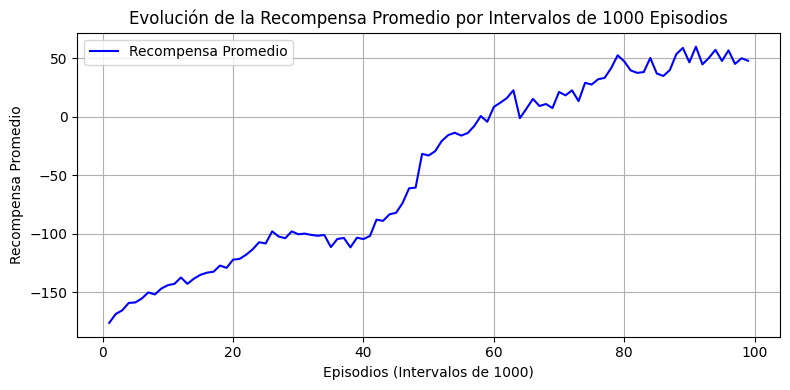

In [9]:
import matplotlib.pyplot as plt

# Datos de recompensa promedio a lo largo de los episodios
episodios_ajustados = list(range(1, 100))

recompensas_promedio = [-176.20306955016136, -168.58455704968458, -165.46163947940332, 
                        -159.1079779172706, -158.7408873799418, -155.35254596596806, 
                        -150.17517571563508, -151.87927619033982, -146.8368828739069, 
                        -143.9601472971231, -142.86026410001023, -137.4240653922457, 
                        -142.8441402646452, -138.38076475013256, -135.12216095934767, 
                        -133.26765784015387, -132.51086075105795, -127.21578470564357, 
                        -129.21646835441652, -122.18803071527458, -121.53665952756339, 
                        -117.97024039640733, -113.37676902189827, -107.28474518095285, 
                        -108.36310796595345, -97.97960686353564, -102.45713854879091, 
                        -103.85964808473206, -98.02357015753726, -100.46459105726052, 
                        -99.92854027665537, -101.03048510343919, -101.78840261668623, 
                        -101.10094086445297, -111.42594856315334, -104.51410070033143, 
                        -103.65329802082564, -111.67078293544165, -103.45041726835494, 
                        -104.60225973359674, -101.93500672048663, -88.0468242493674, 
                        -89.05275206261216, -83.45103475213607, -82.17346974011646, 
                        -73.87556624901248, -61.260104040343414, -60.65530129991435, 
                        -31.82597938227421, -33.21386455013932, -29.54613436041704, 
                        -20.90664881960447, -15.81359331501125, -13.776607445514081, 
                        -16.21237526928025, -14.007025900390015, -8.022534792624263, 
                        0.4943447479674885, -4.397104725753646, 8.270102077599189, 
                        11.890214641862682, 15.823264689745278, 22.51420421786917, 
                        -1.3360442575567135, 6.761501582062048, 15.120121176698643, 
                        9.070306314105679, 10.756541416967181, 7.286203244695063, 
                        21.06394025718615, 18.14391420208414, 22.437774605711684, 
                        13.195077323798824, 28.859037789585408, 27.3869574987898, 
                        31.890808839518634, 33.09361573907141, 41.41472925618187, 
                        52.35827025292043, 47.237797991818795, 39.440168800262626, 
                        37.35540363606143, 38.041067483988506, 50.105681601054236, 
                        36.8159332732155, 34.707313284070345, 39.742129404525954, 
                        53.364928155279884, 58.65866640183804, 46.36556994761686, 
                        59.754190158104784, 44.61570626569137, 50.175108367008406, 
                        57.06405705378321, 47.56064352857761, 56.57726229035566, 
                        44.990093766162424, 49.84738176939405, 47.70266878869875]

# Crear la gráfica
plt.figure(figsize=(8,4))
plt.plot(episodios_ajustados, recompensas_promedio, label='Recompensa Promedio', color='blue')

# Añadir etiquetas y título
plt.xlabel('Episodios (Intervalos de 1000)')
plt.ylabel('Recompensa Promedio')
plt.title('Evolución de la Recompensa Promedio por Intervalos de 1000 Episodios')
plt.legend()
plt.grid(True)
plt.tight_layout()

import matplotlib.pyplot as plt

# Graficar las recompensas de todos los episodios
plt.figure(figsize=(10,6))
plt.plot(recompensa_episodios, label='Recompensa por Episodio', color='blue')
plt.xlabel('Episodios')
plt.ylabel('Recompensa')
plt.title('Recompensa por Episodio en LunarLander')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Mostrar la gráfica
plt.show()


## Análisis de casos (Éxitos y Fallos)

### Reproducir episodios exitosos y no exitosos de los casos de prueba

In [32]:
# Reproducir un episodio específico
episodio_especifico = 31  # Cambia este valor al episodio que quieras reproducir
if episodio_especifico < len(episodios_exitosos):
    reproducir_episodio(agente, episodios_exitosos[episodio_especifico], semillas_exitosas[episodio_especifico])
else:
    print(f"No hay suficientes episodios exitosos para reproducir el episodio {episodio_especifico}")

In [31]:
# Reproducir un episodio específico
episodio_especifico = 203  # Cambia este valor al episodio que quieras reproducir
if episodio_especifico < len(episodios_no_exitosos):
    reproducir_episodio(agente, episodios_no_exitosos[episodio_especifico], semillas_exitosas[episodio_especifico])
else:
    print(f"No hay suficientes episodios no exitosos para reproducir el episodio {episodio_especifico}")

### Episodios Exitosos y no exitosos

La indeterminación del entorno proviene de la discretización, ya que un mismo estado discretizado puede llevar a diferentes resultados dependiendo de pequeñas variaciones no capturadas por la discretización. A pesar de esta limitación, el agente ha aprendido a actuar para un (numero porcentaje) de casos dentro de los 1000 que utilizamos para las pruebas.

Para los casos exitosos vemos que el agente tiene un buen control del propulsor principal para no permitir nunca la caida a una velocidad elevada y tener la oportunidad de acomodarse de manera horizontal hacia la meta. Esto siempre desde un comienzo es controlado, lo cual al encadenar un conjunto de buenas decisiones y dandole siempre el uso justo a los propulsores laterales termina llevandolo a una recompenza exitosa.

Esto es vital al comienzo de la ejecución de acciones de la nave ya que notamos una gran sensibilidad ante las decisiones de propulsarse hacia los costados en momentos inoportunos como se vera corriendo los ejemplos de casos no exitosos.

En cuanto a los episodios que no son exitosos podemos ver que una mala decision de propulsarse hacia un costado, siempre se vuelve muy dificil de corregir para el agente no pudiendo controlar su velocidad y saliendose del entorno dando un caso fallido teniendo tambien la variable de poder girar en su eje complejizando mas su recuperacion al "camino" correcto.

Vemos en otros tantos episodios, que el agente se propulsa hacia arriba por demas, al comienzo de su ejecucion, y creemos que al "salirse" del entorno el caso ya se considera como fallido.

Concluimos que la determinacion del exito del episodio, se basa mucho en las primeras decisiones que toma, dado a la sensibilidad que tienen las decisiones desde un comienzo y su poca habilidad de recuperacion ante malas decisiones.

## Limitantes del agente

In [17]:
# Analizar los resultados aqui
